In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load the data
train_df = pd.read_csv('/Users/arunreddy/Downloads/forecasting-unit-sales-vit-task-2/train.csv')
test_df = pd.read_csv('/Users/arunreddy/Downloads/forecasting-unit-sales-vit-task-2/test.csv')

In [2]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          101490 non-null  object 
 1   date        101490 non-null  object 
 2   Item Id     101488 non-null  object 
 3   Item Name   99658 non-null   object 
 4   ad_spend    77303 non-null   float64
 5   anarix_id   101490 non-null  object 
 6   units       83592 non-null   float64
 7   unit_price  101490 non-null  float64
dtypes: float64(3), object(5)
memory usage: 6.2+ MB
None


In [3]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          2833 non-null   object 
 1   date        2833 non-null   object 
 2   Item Id     2833 non-null   object 
 3   Item Name   2489 non-null   object 
 4   ad_spend    1382 non-null   float64
 5   anarix_id   2833 non-null   object 
 6   unit_price  2833 non-null   float64
dtypes: float64(2), object(5)
memory usage: 155.1+ KB
None


In [4]:
print(train_df.describe())

           ad_spend         units     unit_price
count  77303.000000  83592.000000  101490.000000
mean     110.771470     10.284381     106.750922
std      529.303777     68.945915     425.704733
min        0.000000   -173.000000   -8232.000000
25%        0.000000      0.000000       0.000000
50%        4.230000      1.000000       0.000000
75%       44.310000      5.000000       0.000000
max    47934.990000   9004.000000   21557.390000


In [5]:
# Define target variable
target = 'units'

In [6]:
#Feature Engineering
def add_features(df, is_train=True):
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    
    if is_train:
        df['lag_1'] = df[target].shift(1)
        df['lag_2'] = df[target].shift(2)
        df['lag_3'] = df[target].shift(3)
        df['rolling_mean_3'] = df[target].rolling(window=3).mean()
        df['rolling_std_3'] = df[target].rolling(window=3).std()
        df['rolling_mean_7'] = df[target].rolling(window=7).mean()
        df['rolling_std_7'] = df[target].rolling(window=7).std()
    else:
        # For test data, we don't have 'units' column so we shift using train data
        df['lag_1'] = train_df[target].shift(1).reindex(df.index)
        df['lag_2'] = train_df[target].shift(2).reindex(df.index)
        df['lag_3'] = train_df[target].shift(3).reindex(df.index)
        df['rolling_mean_3'] = train_df[target].rolling(window=3).mean().reindex(df.index)
        df['rolling_std_3'] = train_df[target].rolling(window=3).std().reindex(df.index)
        df['rolling_mean_7'] = train_df[target].rolling(window=7).mean().reindex(df.index)
        df['rolling_std_7'] = train_df[target].rolling(window=7).std().reindex(df.index)

    if is_train:
        return df.dropna()
    else:
        return df.fillna(0) 

In [7]:
print("Train Data Columns: ", train_df.columns)
print("Test Data Columns: ", test_df.columns)

Train Data Columns:  Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units',
       'unit_price'],
      dtype='object')
Test Data Columns:  Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price'],
      dtype='object')


In [8]:
assert 'units' in train_df.columns, "'units' column is missing in train_df"

In [9]:
train_df = add_features(train_df, is_train=True)

In [10]:
features = ['day_of_week', 'month', 'ad_spend', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_7', 'rolling_std_7']
X = train_df[features]
y = train_df[target]

In [11]:
tscv = TimeSeriesSplit(n_splits=3)

In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=0))
])

In [13]:
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 15],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 15],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [14]:
best_model = grid_search.best_estimator_

In [15]:
from sklearn.metrics import mean_squared_error, r2_score


In [16]:
predictions = best_model.predict(X)
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)

In [17]:
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 24.37043821573707
R-squared: 0.9325259001938301


In [18]:
print("Test Data Columns Before Feature Engineering: ", test_df.columns)


Test Data Columns Before Feature Engineering:  Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price'],
      dtype='object')


In [19]:
test_df = add_features(test_df, is_train=False)


In [20]:
print("Test Data Columns After Feature Engineering: ", test_df.columns)


Test Data Columns After Feature Engineering:  Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price', 'day_of_week', 'month', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean_3', 'rolling_std_3', 'rolling_mean_7', 'rolling_std_7'],
      dtype='object')


In [21]:
X_test = test_df[features]

In [22]:
if X_test.empty:
    print("X_test is empty after feature engineering.")
else:
    # Predict on the test data
    test_predictions = best_model.predict(X_test)

    # Prepare submission DataFrame
    submission_df = pd.DataFrame({
    'date': test_df['date'],  # Adjust based on your test data column names
    'Item Id': test_df['Item Id'],  # Adjust based on your test data column names
    'TARGET': test_predictions
    })


In [23]:
submission_df.to_csv('submission.csv', index=False)
print("Submission saved as 'submission.csv'")

Submission saved as 'submission.csv'


In [24]:
print(submission_df.head())

        date     Item Id    TARGET
0 2024-07-01  B09KDR64LT  0.032843
1 2024-07-01  B09KDTS4DC  0.032843
2 2024-07-01  B09KDTHJ6V  0.032843
3 2024-07-01  B09KDQ2BWY  0.032843
4 2024-07-01  B09KDYY3SB  0.032843


In [25]:
submission_df.to_csv('/Users/arunreddy/Downloads/submission.csv', index=False)

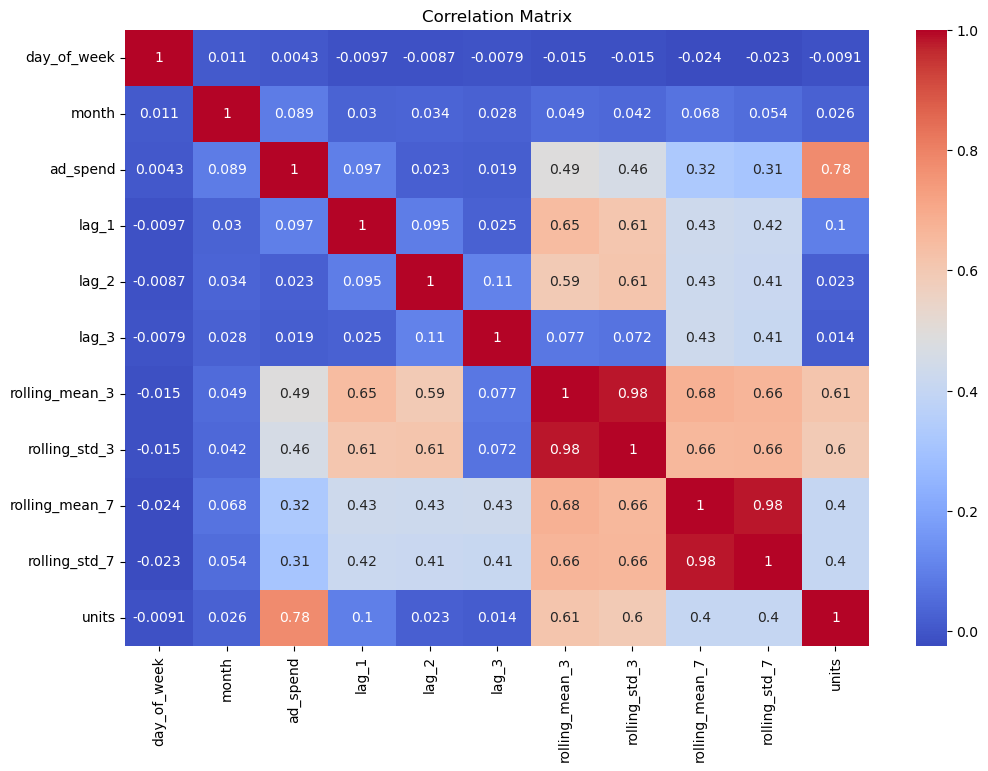

In [26]:
# Visualization: Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = train_df[features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

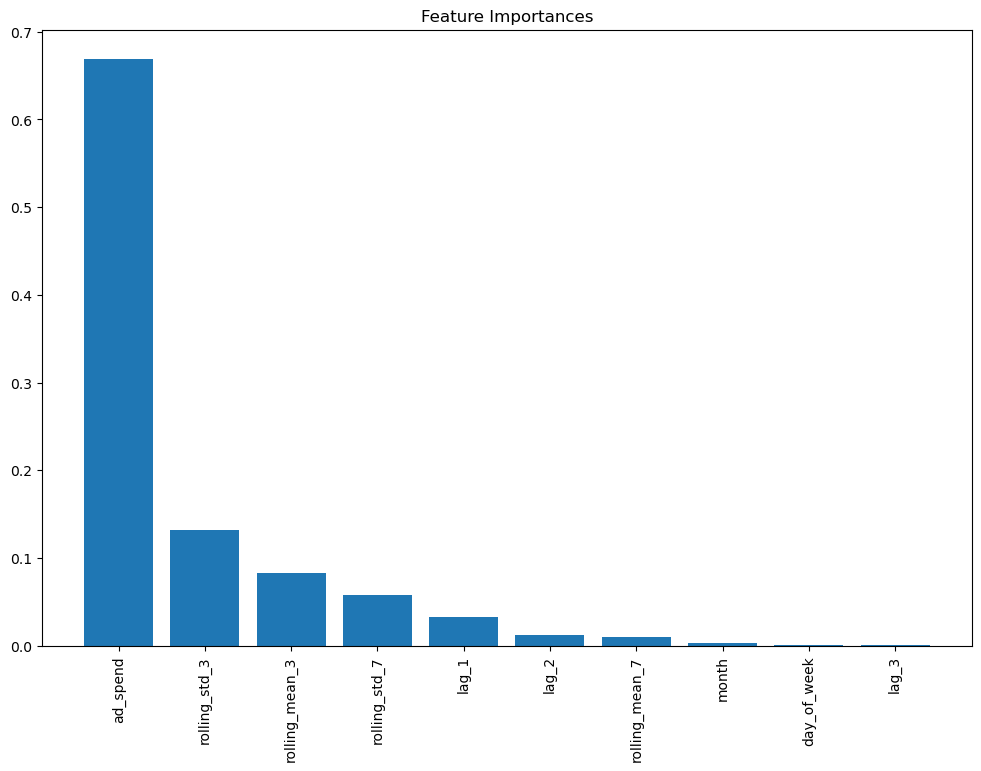

In [27]:
# Visualization: Feature importances
importances = best_model.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

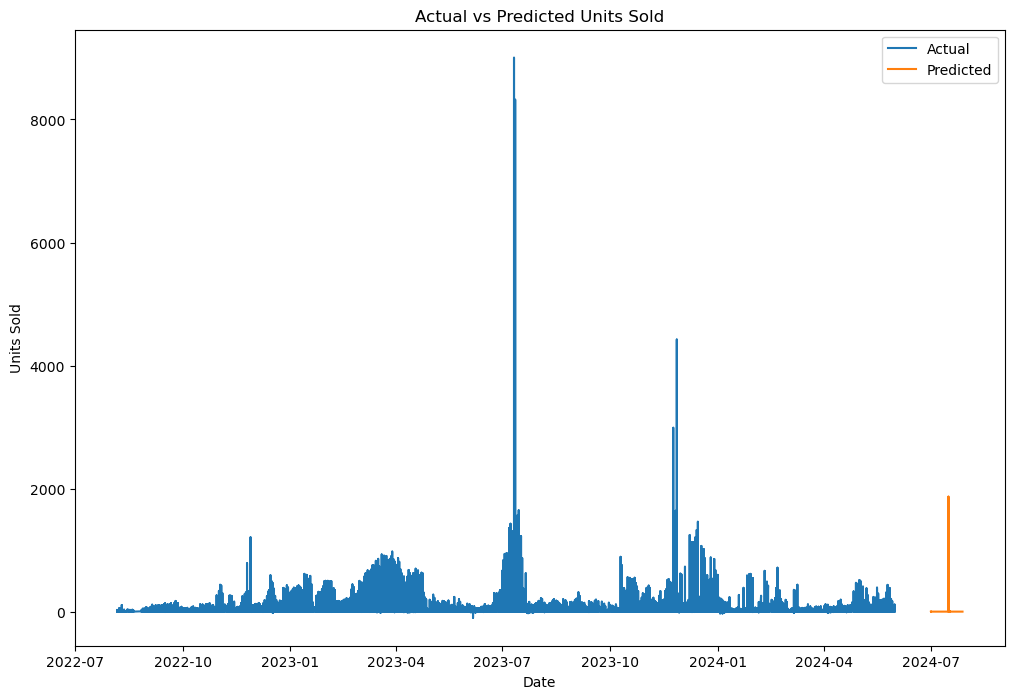

In [28]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(12, 8))
plt.plot(train_df['date'], train_df[target], label='Actual')
plt.plot(test_df['date'], test_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.legend()
plt.show()